
The methodology for this project was inspired by two key papers: *"Cost-sensitive Boosting for Classification of Imbalanced Data"* by Yanmin Sun and Mohamed S. Kamel, and *"One-Benefit Learning: Cost-sensitive Learning with Restricted Cost Information"* by Bianca Zadrozny. Both works provide valuable theoretical and practical approaches for managing missing data and class imbalances.

The project's objective was to develop a model that predicts the binary target variable, **Y_target**, which necessitated the use of a classification framework. Prior to model development, it was essential to address the data imbalance issue. This was achieved using two complementary approaches:

1. **Data-Level Approach:**  
   - **Random Oversampling:** The minority class was first subdivided into sub-concepts using K-means clustering. Each sub-cluster was then oversampled so that its size matched that of the largest cluster. Finally, the oversampled minority data was combined with the majority class data to form a balanced training set.

2. **Algorithmic-Level Approach:**  
   - **Cost-Sensitive Learning:** A cost matrix was developed to incorporate misclassification costs, enabling the model to prioritize the extraction of rare, yet regular, patterns. This approach helped to minimize the overall cost of misclassification.

The implementation of these strategies was carried out using AdaBoost, which naturally integrates cost-sensitive learning with variance and bias reduction, thereby focusing on minimizing misclassifications.

The remainder of the code is self-explanatory. Please note that the dataframes `df_1` and `df_2` are reserved for further analysis and can be disregarded in this context.

In [83]:
import pandas as pd
# getting data

df = pd.read_csv("/Users/anani/OneDrive - Old/Desktop/MSBA/Application of Machine learning/BAN6025Project2Data.csv")

df = pd.DataFrame(df)
df.dropna

<bound method DataFrame.dropna of         Target_Y   X1        X2  X3   X4  X5        X6          X7  X8    X9  \
0              0  0.3  0.986506  -1   25  40  0.006735  102.453711  AA  1059   
1              0  0.8  0.617426  -1   89  20  0.010095   -0.849551  AD  1658   
2              0  0.8  0.996707   9   14  40  0.012316   -1.490386  AB  1095   
3              0  0.6  0.475100  11   14  30  0.006991   -1.863101  AB  3483   
4              0  0.9  0.842307  -1   29  40  5.742626   47.152498  AA  2339   
...          ...  ...       ...  ..  ...  ..       ...         ...  ..   ...   
999995         0  0.8  0.124690  -1  143  30  0.051348   -0.826239  AB   530   
999996         0  0.9  0.824544  -1  193  30  0.009591    0.008307  AC   408   
999997         0  0.8  0.140891  -1  202  10  0.059287   50.609995  AA   749   
999998         0  0.9  0.002480  52    3  30  0.023357   -1.313387  AB   707   
999999         0  0.6  0.993391  -1  174  30  0.020422   14.942456  AA   655   

     

### Splitting the data

In [84]:
'''
# exploratory EDA
df_1 = df.loc[:, 'Target_Y':'X15']
#df_1.head(20)
df_1.dtypes

# Assume 'Y_target' is the first column and you want all columns starting at 'X16' as well.
# First, get the columns from 'X16' onward.
columns_from_X16 = list(df.loc[:, 'X16':].columns)

# Then, create a new DataFrame that includes 'Y_target' and the selected columns.
df_2 = df[['Target_Y'] + columns_from_X16]

df_2.head(20)
'''

"\n# exploratory EDA\ndf_1 = df.loc[:, 'Target_Y':'X15']\n#df_1.head(20)\ndf_1.dtypes\n\n# Assume 'Y_target' is the first column and you want all columns starting at 'X16' as well.\n# First, get the columns from 'X16' onward.\ncolumns_from_X16 = list(df.loc[:, 'X16':].columns)\n\n# Then, create a new DataFrame that includes 'Y_target' and the selected columns.\ndf_2 = df[['Target_Y'] + columns_from_X16]\n\ndf_2.head(20)\n"

### Resampling the data



C:\Users\anani\AppData\Local\Temp\ipykernel_17660\2097179568.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_balanced, palette="viridis")


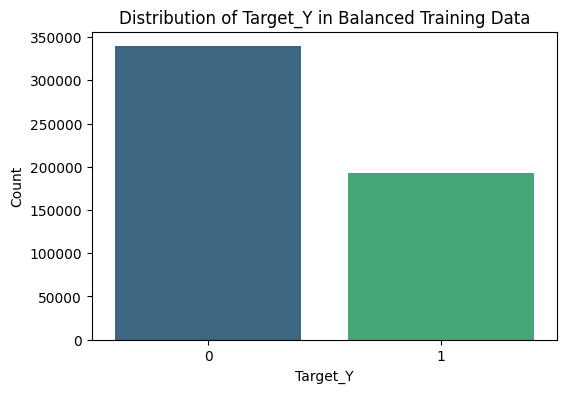

Counts in original training set:
 Target_Y
0    339216
1    169607
Name: count, dtype: int64

Counts in balanced training set:
 Target_Y
0    339216
1    192243
Name: count, dtype: int64


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# -------------------------------
# Assume that X and y are already defined.
# For example:
# X = df.drop(columns=['Target_Y'])
# y = df['Target_Y']
# -------------------------------

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Combine X_train and y_train for easier manipulation
train_data = X_train.copy()
train_data['Target_Y'] = y_train

# Step 1: Isolate the minority class (assumed to be class 1) and the majority class
minority_data = train_data[train_data['Target_Y'] == 1].copy()
majority_data = train_data[train_data['Target_Y'] == 0].copy()

# -------------------------------
# Step 2: Detect sub-concepts within the minority class using clustering
# Choose a subset of features (typically numeric) for clustering.
# (Assumes features are already scaled/normalized if needed.)
n_clusters = 3  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# Use all columns except 'Target_Y' for clustering
minority_features = minority_data.drop(columns=['Target_Y'])
minority_data['cluster'] = kmeans.fit_predict(minority_features)

# -------------------------------
# Step 3: Adjusted Oversampling of each cluster
# Here, instead of oversampling to the size of the largest cluster, we set a target:
# We want the overall minority class count to reach 50% of the majority count.
majority_count = majority_data.shape[0]
target_minority_total = int(0.5 * majority_count)
# Distribute the target evenly among the clusters
desired_cluster_count = target_minority_total // n_clusters

oversampled_minority_list = []  # To store oversampled data for each cluster

for cluster_label in range(n_clusters):
    cluster_subset = minority_data[minority_data['cluster'] == cluster_label].copy()
    
    # Prepare features and target for oversampling
    X_cluster = cluster_subset.drop(columns=['Target_Y', 'cluster'])
    y_cluster = cluster_subset['Target_Y']
    
    current_count = X_cluster.shape[0]
    desired_n_samples = desired_cluster_count  # Our new target for this cluster

    # If the current cluster count is less than the desired number, oversample it
    if current_count < desired_n_samples:
        # Calculate how many full replications are needed and the remainder
        n_repeats = desired_n_samples // current_count
        remainder = desired_n_samples % current_count
        
        # Replicate the cluster data
        X_rep = pd.concat([X_cluster] * n_repeats, ignore_index=True)
        y_rep = pd.concat([y_cluster] * n_repeats, ignore_index=True)
        
        # If there's a remainder, randomly sample extra rows from the cluster
        if remainder > 0:
            extra = X_cluster.sample(n=remainder, random_state=42)
            extra_y = y_cluster.loc[extra.index]
            X_rep = pd.concat([X_rep, extra], ignore_index=True)
            y_rep = pd.concat([y_rep, extra_y], ignore_index=True)
        
        # Reconstruct a DataFrame for the oversampled cluster
        cluster_oversampled = X_rep.copy()
        cluster_oversampled['Target_Y'] = y_rep
        # Add back the cluster label (optional)
        cluster_oversampled['cluster'] = cluster_label
    else:
        # If the cluster already meets or exceeds the target, keep it as is
        cluster_oversampled = cluster_subset.copy()
    
    oversampled_minority_list.append(cluster_oversampled)

# Combine the oversampled minority clusters
oversampled_minority = pd.concat(oversampled_minority_list, ignore_index=True)

# Step 4: Combine the oversampled minority with the original majority data
balanced_train_data = pd.concat([majority_data, oversampled_minority], ignore_index=True)

# Optionally, shuffle the combined dataset
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target again for training
X_train_balanced = balanced_train_data.drop(columns=['Target_Y', 'cluster'])
y_train_balanced = balanced_train_data['Target_Y']

# -------------------------------
# Plotting a Histogram to Compare 0s and 1s in the Balanced Data
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_balanced, palette="viridis")
plt.title("Distribution of Target_Y in Balanced Training Data")
plt.xlabel("Target_Y")
plt.ylabel("Count")
plt.xticks([0, 1])
plt.show()

# (Optional) Print counts to verify numeric balance:
print("Counts in original training set:\n", y_train.value_counts())
print("\nCounts in balanced training set:\n", y_train_balanced.value_counts())


In [86]:
print("Before resampling:", y_train.value_counts())
print("After resampling:", y_train_balanced.value_counts())


Before resampling: Target_Y
0    339216
1    169607
Name: count, dtype: int64
After resampling: Target_Y
0    339216
1    192243
Name: count, dtype: int64


### ADAboost with multiple iterations 

Running the model on the full data set

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# -------------------------------
# Data Preprocessing
# -------------------------------
# Here, we are using the balanced training set from your resampling procedure.
X = X_train_balanced.copy()
y = y_train_balanced.copy()

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# -------------------------------
# Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -------------------------------
# AdaBoost Model Training
# -------------------------------
# Use a DecisionTreeClassifier with max_depth=1 as the base estimator (a decision stump)
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
ada_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,        # Adjust the number of weak learners if needed
    learning_rate=1.0,      # Adjust the learning rate as needed
    random_state=42
)

# Fit the AdaBoost model on the training data
ada_model.fit(X_train, y_train)

# -------------------------------
# Predictions & Evaluation
# -------------------------------

# Training set predictions
y_train_pred = ada_model.predict(X_train)
print("Training Set Performance:")
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

# Testing set predictions
y_test_pred = ada_model.predict(X_test)
print("Test Set Performance:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# -------------------------------
# Aggregated Overall Metrics
# -------------------------------

# For an overall combined metric across both classes, we can use a weighted average.
precision_overall = precision_score(y_test, y_test_pred, average='weighted')
recall_overall    = recall_score(y_test, y_test_pred, average='weighted')
f1_overall        = f1_score(y_test, y_test_pred, average='weighted')

print("Overall (Weighted) Metrics on Test Set:")
print(f"Precision: {precision_overall:.4f}")
print(f"Recall:    {recall_overall:.4f}")
print(f"F1 Score:  {f1_overall:.4f}")


Training Set Performance:
Confusion Matrix:
[[211272  26179]
 [ 54233  80337]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84    237451
           1       0.75      0.60      0.67    134570

    accuracy                           0.78    372021
   macro avg       0.77      0.74      0.75    372021
weighted avg       0.78      0.78      0.78    372021

Test Set Performance:
Confusion Matrix:
[[90624 11141]
 [23541 34132]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84    101765
           1       0.75      0.59      0.66     57673

    accuracy                           0.78    159438
   macro avg       0.77      0.74      0.75    159438
weighted avg       0.78      0.78      0.78    159438

Overall (Weighted) Metrics on Test Set:
Precision: 0.7794
Recall:    0.7825
F1 Score:  0.7756


#### Final Score

#### running the model to get a aggregated  score

Training Set Metrics:
Accuracy: 0.7838509116420848
Precision: 0.7542247174133464
Recall: 0.5969904139109757
F1 Score: 0.6664592717951271

Test Set Metrics:
Accuracy: 0.7824734379508022
Precision: 0.7539151370574073
Recall: 0.5918193955577133
F1 Score: 0.6631049287976221


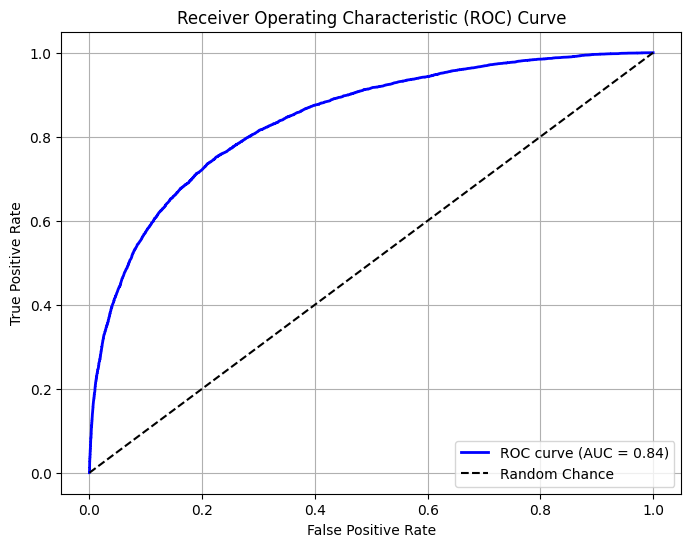

In [88]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# -------------------------------
# Data Preprocessing
# -------------------------------
# Use your balanced training set from the resampling procedure.
# Assume X_train_balanced and y_train_balanced are already defined.
X = X_train_balanced.copy()
y = y_train_balanced.copy()

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# -------------------------------
# Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -------------------------------
# AdaBoost Model Training
# -------------------------------
# Use a DecisionTreeClassifier with max_depth=1 as the base estimator.
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
ada_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,       # Adjust number of weak learners as needed
    learning_rate=1.0,     # Adjust learning rate if necessary
    random_state=42
)
ada_model.fit(X_train, y_train)

# -------------------------------
# Evaluate Model on Training Set
# -------------------------------
y_train_pred = ada_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("Training Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

# -------------------------------
# Evaluate Model on Test Set
# -------------------------------
y_test_pred = ada_model.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")

# -------------------------------
# ROC Curve and AUC Calculation
# -------------------------------
# Get the predicted probabilities for the positive class
y_test_proba = ada_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
